In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from snorkel.learning import GenerativeModel
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
from data_loader import DataLoader
loader = DataLoader()

In [3]:
# Generate Primitives
def has_bike(object_names):
    if ('cycle' in object_names) or ('bike' in object_names) or ('bicycle' in object_names):
        return 1
    else:
        return 0
def has_human(object_names):
    if (('person' in object_names) or ('woman' in object_names) or ('man' in object_names)) \
        and (('bicycle' in object_names) or 'bicycles' in object_names):
        return 1
    else:
        return 0
def has_road(object_names):
    if ('road' in object_names) or ('street' in object_names) or ('concrete' in object_names):
        return 1
    else:
        return 0
def has_cars(object_names):
    if ('car' in object_names) or ('cars' in object_names) or \
        ('bus' in object_names) or ('buses' in object_names) or \
        ('truck' in object_names) or ('trucks' in object_names):
        return 1
    else:
        return 0

In [4]:
from primitive_helpers import bike_human_distance, bike_human_size, bike_human_nums

def create_primitives(loader):
    m = 7 # number of primitives
    primitive_mtx = np.zeros((loader.train_num,m))

    for i in range(loader.train_num):
        primitive_mtx[i,0] = has_human(loader.train_object_names[i])
        primitive_mtx[i,1] = has_road(loader.train_object_names[i])
        primitive_mtx[i,2] = has_cars(loader.train_object_names[i])
        primitive_mtx[i,3] = has_bike(loader.train_object_names[i])

        primitive_mtx[i,4] = bike_human_distance(loader.train_object_names[i], 
                                                 loader.train_object_x[i], 
                                                 loader.train_object_y[i])

        area = np.multiply(loader.train_object_height[i], loader.train_object_width[i])
        primitive_mtx[i,5] = bike_human_size(loader.train_object_names[i], area)
        primitive_mtx[i,6] = bike_human_nums(loader.train_object_names[i])

    return primitive_mtx
primitive_mtx = create_primitives(loader)

p_keys = {
    'has_human': primitive_mtx[:,0],
    'has_road': primitive_mtx[:, 1],
    'has_cars': primitive_mtx[:, 2],
    'has_bike': primitive_mtx[:, 3],
    'bike_human_distance': primitive_mtx[:, 4],
    'bike_human_size': primitive_mtx[:, 5],
    'bike_human_num': primitive_mtx[:, 6]
   }
pos = list(np.where(loader.train_ground>0)[0])
neg = list(np.where(loader.train_ground<0)[0])[-len(pos):]
ind = pos + neg
print(len(ind))
loader.train_ground = loader.train_ground[ind]
loader.train_num = len(ind)

540


In [5]:
# create labeling functions
x1 = []
x2 = []
def LF_street(has_human, has_road):
    if has_human >= 1: 
        if has_road >= 1:
            return 1
        else:
            return -1
    return 0

def LF_vehicles(has_human, has_cars):
    if has_human >= 1: 
        if has_cars >= 1:
            return 1
        else:
            return -1
    return 0

def LF_distance(has_human, has_bike, bike_human_distance, alpha=8):
    if has_human >= 1:
        if has_bike >= 1: 
            x1.append(bike_human_distance)
            if bike_human_distance <= alpha:
                return 1
            else:
                return -1
    else:
        return -1
    
def LF_size(has_human, has_bike, bike_human_size, beta=1000):
    if has_human >= 1:
        if has_bike >= 1: 
            x2.append(bike_human_size)
            if bike_human_size <= beta:
                return 1
            else:
                return -1
    else:
        return -1
    
    
def LF_number(has_human, has_bike, bike_human_num):
    if has_human >= 1:
        if has_bike >= 1: 
            if bike_human_num >= 2:
                return 1
            if bike_human_num >= 1:
                return 0
            if bike_human_num >= 0:
                return 1
    else:
        return -1
for j in range(len(ind)):
        i = ind[j]
        LF_distance(p_keys['has_human'][i], p_keys['has_bike'][i], p_keys['bike_human_distance'][i])
        LF_size(p_keys['has_human'][i], p_keys['has_bike'][i], p_keys['bike_human_size'][i])

## Test the influence of different ratio for labeling functions

In [6]:
from functools import partial
# alpha=8, beta=1000 are chosen in previous tutorial 
# use balanced data now, 

def dif_ratio(alpha, beta):
    LF_distance_alpha = partial(LF_distance, alpha=alpha)
    LF_size_beta = partial(LF_size, beta=beta)
    L_fns = [LF_street,LF_vehicles,LF_distance_alpha,LF_size_beta,LF_number]
    L = np.zeros((len(L_fns),loader.train_num)).astype(int)
    print(L.shape)
    for j in range(len(ind)):
        i = ind[j]
        L[0,j] = L_fns[0](p_keys['has_human'][i], p_keys['has_road'][i])
        L[1,j] = L_fns[1](p_keys['has_human'][i], p_keys['has_cars'][i])
        L[2,j] = L_fns[2](p_keys['has_human'][i], p_keys['has_bike'][i], p_keys['bike_human_distance'][i])
        L[3,j] = L_fns[3](p_keys['has_human'][i], p_keys['has_bike'][i], p_keys['bike_human_size'][i])
        L[4,j] = L_fns[4](p_keys['has_human'][i], p_keys['has_bike'][i], p_keys['bike_human_num'][i])
    print(np.sum(L[2,:]), np.sum(L[3,:]))
    L_train = sparse.csr_matrix(L.T)
    #mv_labels = np.sign(np.sum(L.T,1))
    #mv_labels[mv_labels==0] = -1
    #mv = np.mean(mv_labels == loader.train_ground)
    gen_model = GenerativeModel()
    gen_model.train(L.T, epochs=1000, decay=0.95, step_size= 0.01/ L.shape[1], reg_param=1e-6)
    train_marginals = gen_model.marginals(L_train)
    labels = 2 * (train_marginals > 0.5) - 1
    gen = np.mean(labels == loader.train_ground)
    #print(mv, gen)
    return gen
    

In [7]:
alpha = np.percentile(x1, [10*i for i in range(10)])
beta = np.percentile(x2, [10*i for i in range(10)])
m, n = len(alpha), len(beta)
gen_pred = np.zeros((m, n))
for i in range(m):
    for j in range(n):
        gen_pred[i,j] = dif_ratio(alpha[i], beta[j])
        
        

(5, 540)
-530 -538
Inferred cardinality: 2
(5, 540)
-530 -488
Inferred cardinality: 2
(5, 540)
-530 -436
Inferred cardinality: 2
(5, 540)
-530 -384
Inferred cardinality: 2
(5, 540)
-530 -334
Inferred cardinality: 2
(5, 540)
-530 -282
Inferred cardinality: 2
(5, 540)
-530 -230
Inferred cardinality: 2
(5, 540)
-530 -180
Inferred cardinality: 2
(5, 540)
-530 -128
Inferred cardinality: 2
(5, 540)
-530 -76
Inferred cardinality: 2
(5, 540)
-484 -538
Inferred cardinality: 2
(5, 540)
-484 -488
Inferred cardinality: 2
(5, 540)
-484 -436
Inferred cardinality: 2
(5, 540)
-484 -384
Inferred cardinality: 2
(5, 540)
-484 -334
Inferred cardinality: 2
(5, 540)
-484 -282
Inferred cardinality: 2
(5, 540)
-484 -230
Inferred cardinality: 2
(5, 540)
-484 -180
Inferred cardinality: 2
(5, 540)
-484 -128
Inferred cardinality: 2
(5, 540)
-484 -76
Inferred cardinality: 2
(5, 540)
-426 -538
Inferred cardinality: 2
(5, 540)
-426 -488
Inferred cardinality: 2
(5, 540)
-426 -436
Inferred cardinality: 2
(5, 540)
-426

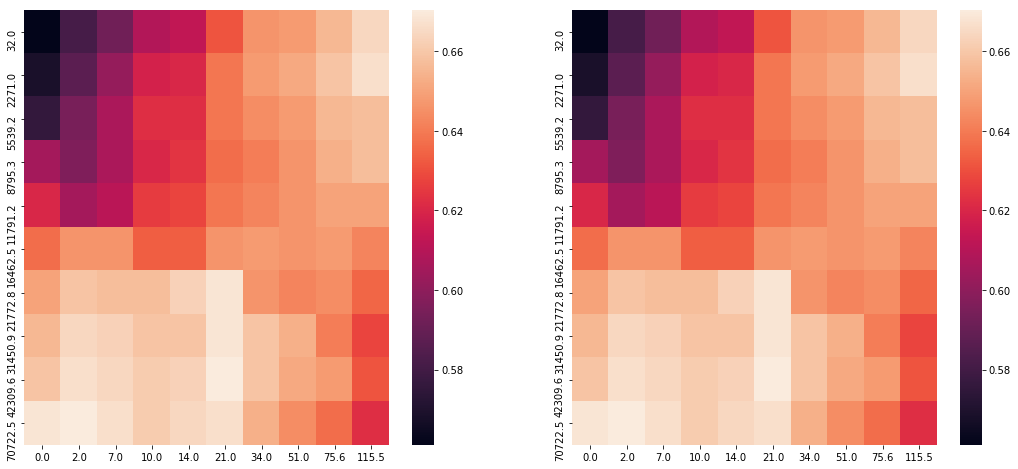

In [11]:
import seaborn as sns
fig,axn = plt.subplots(1, 2, figsize=(18,8))

df = [gen_pred, gen_pred]
i = 0
for ax in axn.flat:
    sns.heatmap(df[i], ax=ax, xticklabels=alpha, yticklabels=beta)
    i += 1
plt.show()
# left panel for majority vote, right panel for generative model